Pregledovanje lastnosti grafov ali so PTC ali pa Kaktusni grafi, maximalna stopnja grafov in pa stevilo ciklov dolzine 3, 4, 5, 6 za max in  min grafe posebej.

Spodnja funkcija preveri ali velja implikacija na najinih rezultatih knorov izrek
UGOTOVITEV: Izrek drzi, saj vse grafe za max_subpath_number, ki so kaktusni vrne tudi true da je PTC graf

In [ ]:
import pandas as pd
from sage.all import *
from itertools import combinations

vhod = "2del_subpath_SA.csv"
izhod = "pregledovanje_lastnosti_subpath.csv"


# -------------------------------------------------
# inducirani cikli dolžine 3,4,5,6
# -------------------------------------------------
def induced_cycles(G, lengths=(3,4,5,6)):
    """
    Vrne seznam ciklov (kot množice vozlišč),
    inducirani cikli za podane dolžine.
    """
    V = G.vertices()
    cycles = []

    for k in lengths:
        for S in combinations(V, k):
            H = G.subgraph(S)
            if H.is_connected() and H.size() == k:
                if all(d == 2 for d in H.degree()):
                    cycles.append(set(S))

    return cycles


# -------------------------------------------------
# KAKTUS
# -------------------------------------------------
def is_cactus(G):
    cycles = G.cycle_basis()
    for i in range(len(cycles)):
        for j in range(i + 1, len(cycles)):
            if len(set(cycles[i]) & set(cycles[j])) > 1:
                return False
    return True


# -------------------------------------------------
# PTC (na osnovi induciranih ciklov)
# -------------------------------------------------
def is_PTC_from_cycles(cycles):
    for i in range(len(cycles)):
        for j in range(i + 1, len(cycles)):
            if len(cycles[i] & cycles[j]) > 2:
                return False
    return True


# -------------------------------------------------
# obdelava CSV
# -------------------------------------------------
def obdelaj_csv(vhod, izhod, mode="both"):

    df = pd.read_csv(vhod, dtype=str, keep_default_na=False)

    if mode in ("min", "both"):
        df["PTC_min"] = ""
        df["KAKTUS_min"] = ""
        df["DVODELEN_min"] = ""
        df["MAX_DEG_min"] = ""
        for k in [3,4,5,6]:
            df[f"C{k}_min"] = ""

    if mode in ("max", "both"):
        df["PTC_max"] = ""
        df["KAKTUS_max"] = ""
        df["DVODELEN_max"] = ""
        df["MAX_DEG_max"] = ""
        for k in [3,4,5,6]:
            df[f"C{k}_max"] = ""

    for i, row in df.iterrows():

        # ---------- MIN ----------
        if mode in ("min", "both"):
            try:
                G = Graph(row["graph6_min"])
                cycles = induced_cycles(G)

                df.at[i, "PTC_min"] = str(is_PTC_from_cycles(cycles)).lower()
                df.at[i, "KAKTUS_min"] = str(is_cactus(G)).lower()
                df.at[i, "DVODELEN_min"] = str(G.is_bipartite()).lower()
                df.at[i, "MAX_DEG_min"] = max(G.degree())

                for k in [3,4,5,6]:
                    df.at[i, f"C{k}_min"] = sum(1 for c in cycles if len(c) == k)

            except:
                df.at[i, "PTC_min"] = "false"
                df.at[i, "KAKTUS_min"] = "false"
                df.at[i, "DVODELEN_min"] = "false"
                df.at[i, "MAX_DEG_min"] = ""
                for k in [3,4,5,6]:
                    df.at[i, f"C{k}_min"] = ""

        # ---------- MAX ----------
        if mode in ("max", "both"):
            try:
                G = Graph(row["graph6_max"])
                cycles = induced_cycles(G)

                df.at[i, "PTC_max"] = str(is_PTC_from_cycles(cycles)).lower()
                df.at[i, "KAKTUS_max"] = str(is_cactus(G)).lower()
                df.at[i, "DVODELEN_max"] = str(G.is_bipartite()).lower()
                df.at[i, "MAX_DEG_max"] = max(G.degree())

                for k in [3,4,5,6]:
                    df.at[i, f"C{k}_max"] = sum(1 for c in cycles if len(c) == k)

            except:
                df.at[i, "PTC_max"] = "false"
                df.at[i, "KAKTUS_max"] = "false"
                df.at[i, "DVODELEN_max"] = "false"
                df.at[i, "MAX_DEG_max"] = ""
                for k in [3,4,5,6]:
                    df.at[i, f"C{k}_max"] = ""

    df.to_csv(izhod, index=False)
    return df


obdelaj_csv(vhod, izhod, mode="both")


In [19]:
import pandas as pd

def preveri_kaktus_ptc_max(ime_csv):
    df = pd.read_csv(ime_csv, dtype=str, keep_default_na=False)

    # normalizacija na lowercase
    kaktus = df["KAKTUS_max"].str.lower()
    ptc    = df["PTC_max"].str.lower()

    # vrstice, kjer je kaktus_max = true, ptc_max pa NI true
    mask = (kaktus == "true") & (ptc != "true")

    if mask.any():
        print("Najdene napake (KAKTUS_max = true, PTC_max != true):")
        print(df[mask])
    else:
        print("Vse OK: kjer je KAKTUS_max = true, je tudi PTC_max = true.")

    return df[mask]

# primer klica
napake = preveri_kaktus_ptc_max("pregledovanje_lastnosti_subpath.csv")


Vse OK: kjer je KAKTUS_max = true, je tudi PTC_max = true.


In [16]:
from sage.all import *
from itertools import combinations

def count_C3_C6_from_graph6(g6):
    """
    Vrne slovar s številom ciklov dolžine 3,4,5,6.
    """
    G = Graph(g6)
    V = G.vertices()

    counts = {3: 0, 4: 0, 5: 0, 6: 0}

    for k in [3, 4, 5, 6]:
        for S in combinations(V, k):
            H = G.subgraph(S)
            if H.is_connected() and H.size() == k:
                if all(d == 2 for d in H.degree()):
                    counts[k] += 1

    return counts

count_C3_C6_from_graph6("DV{")


{3: 5, 4: 0, 5: 0, 6: 0}

Malo risanja grafov

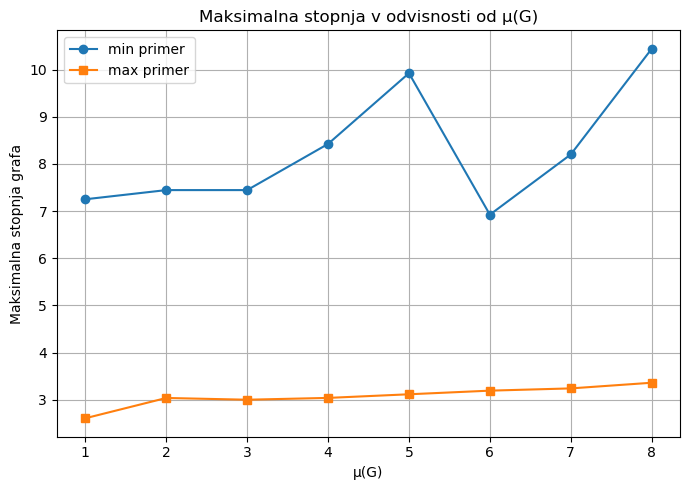

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# naloži CSV
df = pd.read_csv("pregledovanje_lastnosti_subpath.csv")

# poskrbi za pravilne tipe
df["µ(G)"] = df["µ(G)"].astype(int)
df["MAX_DEG_min"] = df["MAX_DEG_min"].astype(int)
df["MAX_DEG_max"] = df["MAX_DEG_max"].astype(int)

# agregacija po µ
agg = df.groupby("µ(G)").agg(
    max_deg_min=("MAX_DEG_min", "mean"),
    max_deg_max=("MAX_DEG_max", "mean")
).reset_index()

# graf
plt.figure(figsize=(7,5))
plt.plot(agg["µ(G)"], agg["max_deg_min"], marker="o", label="min primer")
plt.plot(agg["µ(G)"], agg["max_deg_max"], marker="s", label="max primer")

plt.xlabel("µ(G)")
plt.ylabel("Maksimalna stopnja grafa")
plt.title("Maksimalna stopnja v odvisnosti od µ(G)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


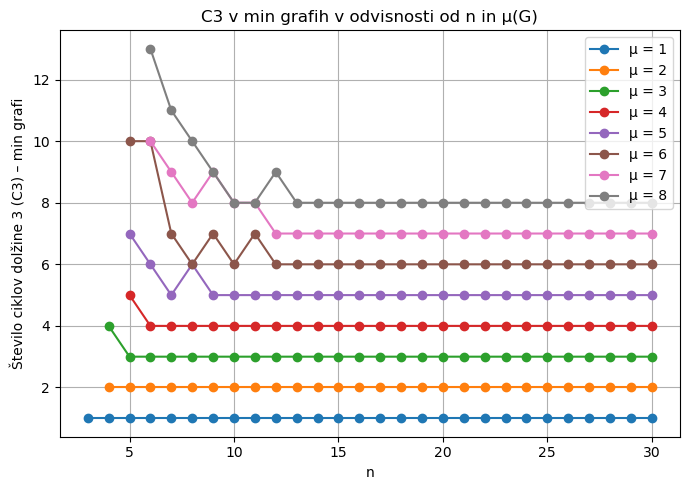

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# naloži podatke
df = pd.read_csv("pregledovanje_lastnosti_subpath.csv")

# tipi
df["n"] = df["n"].astype(int)
df["µ(G)"] = df["µ(G)"].astype(int)
df["C3_min"] = df["C3_min"].astype(int)

plt.figure(figsize=(7,5))

for mu in sorted(df["µ(G)"].unique()):
    sub = df[df["µ(G)"] == mu].sort_values("n")
    plt.plot(sub["n"], sub["C3_min"], marker="o", label=f"µ = {mu}")

plt.xlabel("n")
plt.ylabel("Število ciklov dolžine 3 (C3) – min grafi")
plt.title("C3 v min grafih v odvisnosti od n in µ(G)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



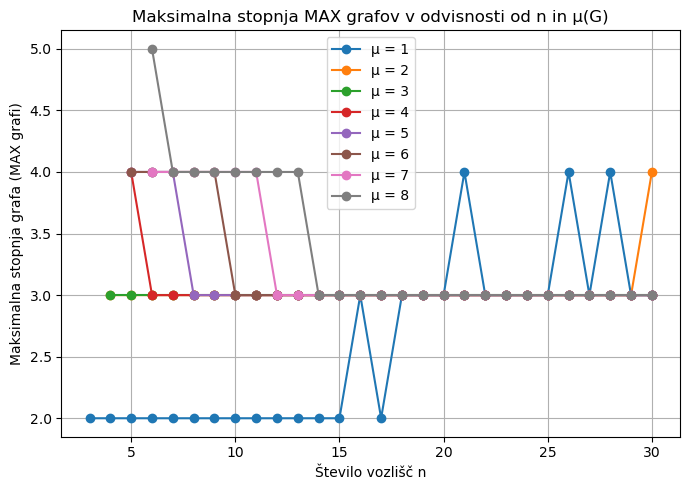

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("pregledovanje_lastnosti_subpath.csv")

# tipi
df["n"] = df["n"].astype(int)
df["µ(G)"] = df["µ(G)"].astype(int)
df["MAX_DEG_max"] = pd.to_numeric(df["MAX_DEG_max"], errors="coerce")

plt.figure(figsize=(7,5))

for mu in sorted(df["µ(G)"].unique()):
    sub = df[df["µ(G)"] == mu].sort_values("n")
    plt.plot(
        sub["n"],
        sub["MAX_DEG_max"],
        marker="o",
        label=f"µ = {mu}"
    )

plt.xlabel("Število vozlišč n")
plt.ylabel("Maksimalna stopnja grafa (MAX grafi)")
plt.title("Maksimalna stopnja MAX grafov v odvisnosti od n in µ(G)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
